<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/CRYPTO_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/insiderfinance/the-code-of-accountability-evaluating-cryptocurrency-algorithmic-trading-performance-76d33b2f6c16

In [1]:
!pip install ccxt pandas numpy ta-lib  -q
!pip install ta -q
#Install required packages
!pip install matplotlib seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls  /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db

/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db


## FINAL

Attempting to load data from: /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db with portfolio filter...

══════════════════📊 PERFORMANCE ANALYSIS REPORT (CLEAN DATA) ═══════════════════
Generated: 2025-12-28 18:12:38.586599
════════════════════════════════════════════════════════════════════════════════

────────────────────📈 CYCLE PERFORMANCE SUMMARY (HEAD/TAIL) ────────────────────
Head (First 5 Cycles):
cycle_number                        timestamp  portfolio_value  total_return_pct  max_drawdown_pct  sharpe_ratio  total_trades  winning_trades  total_pnl  runtime_hours
           1 2025-10-14 17:23:56.446646-04:00      1000.000000          0.000000          0.000000      0.000000             0             0.0   0.000000       0.047679
           2 2025-10-14 17:56:41.196681-04:00      1000.000000          0.000000          0.001336    -93.594872             0             0.0   0.000000       0.618750
           3 2025-10-14 18:30:57.064752-04:00      1000.000000          0.0000

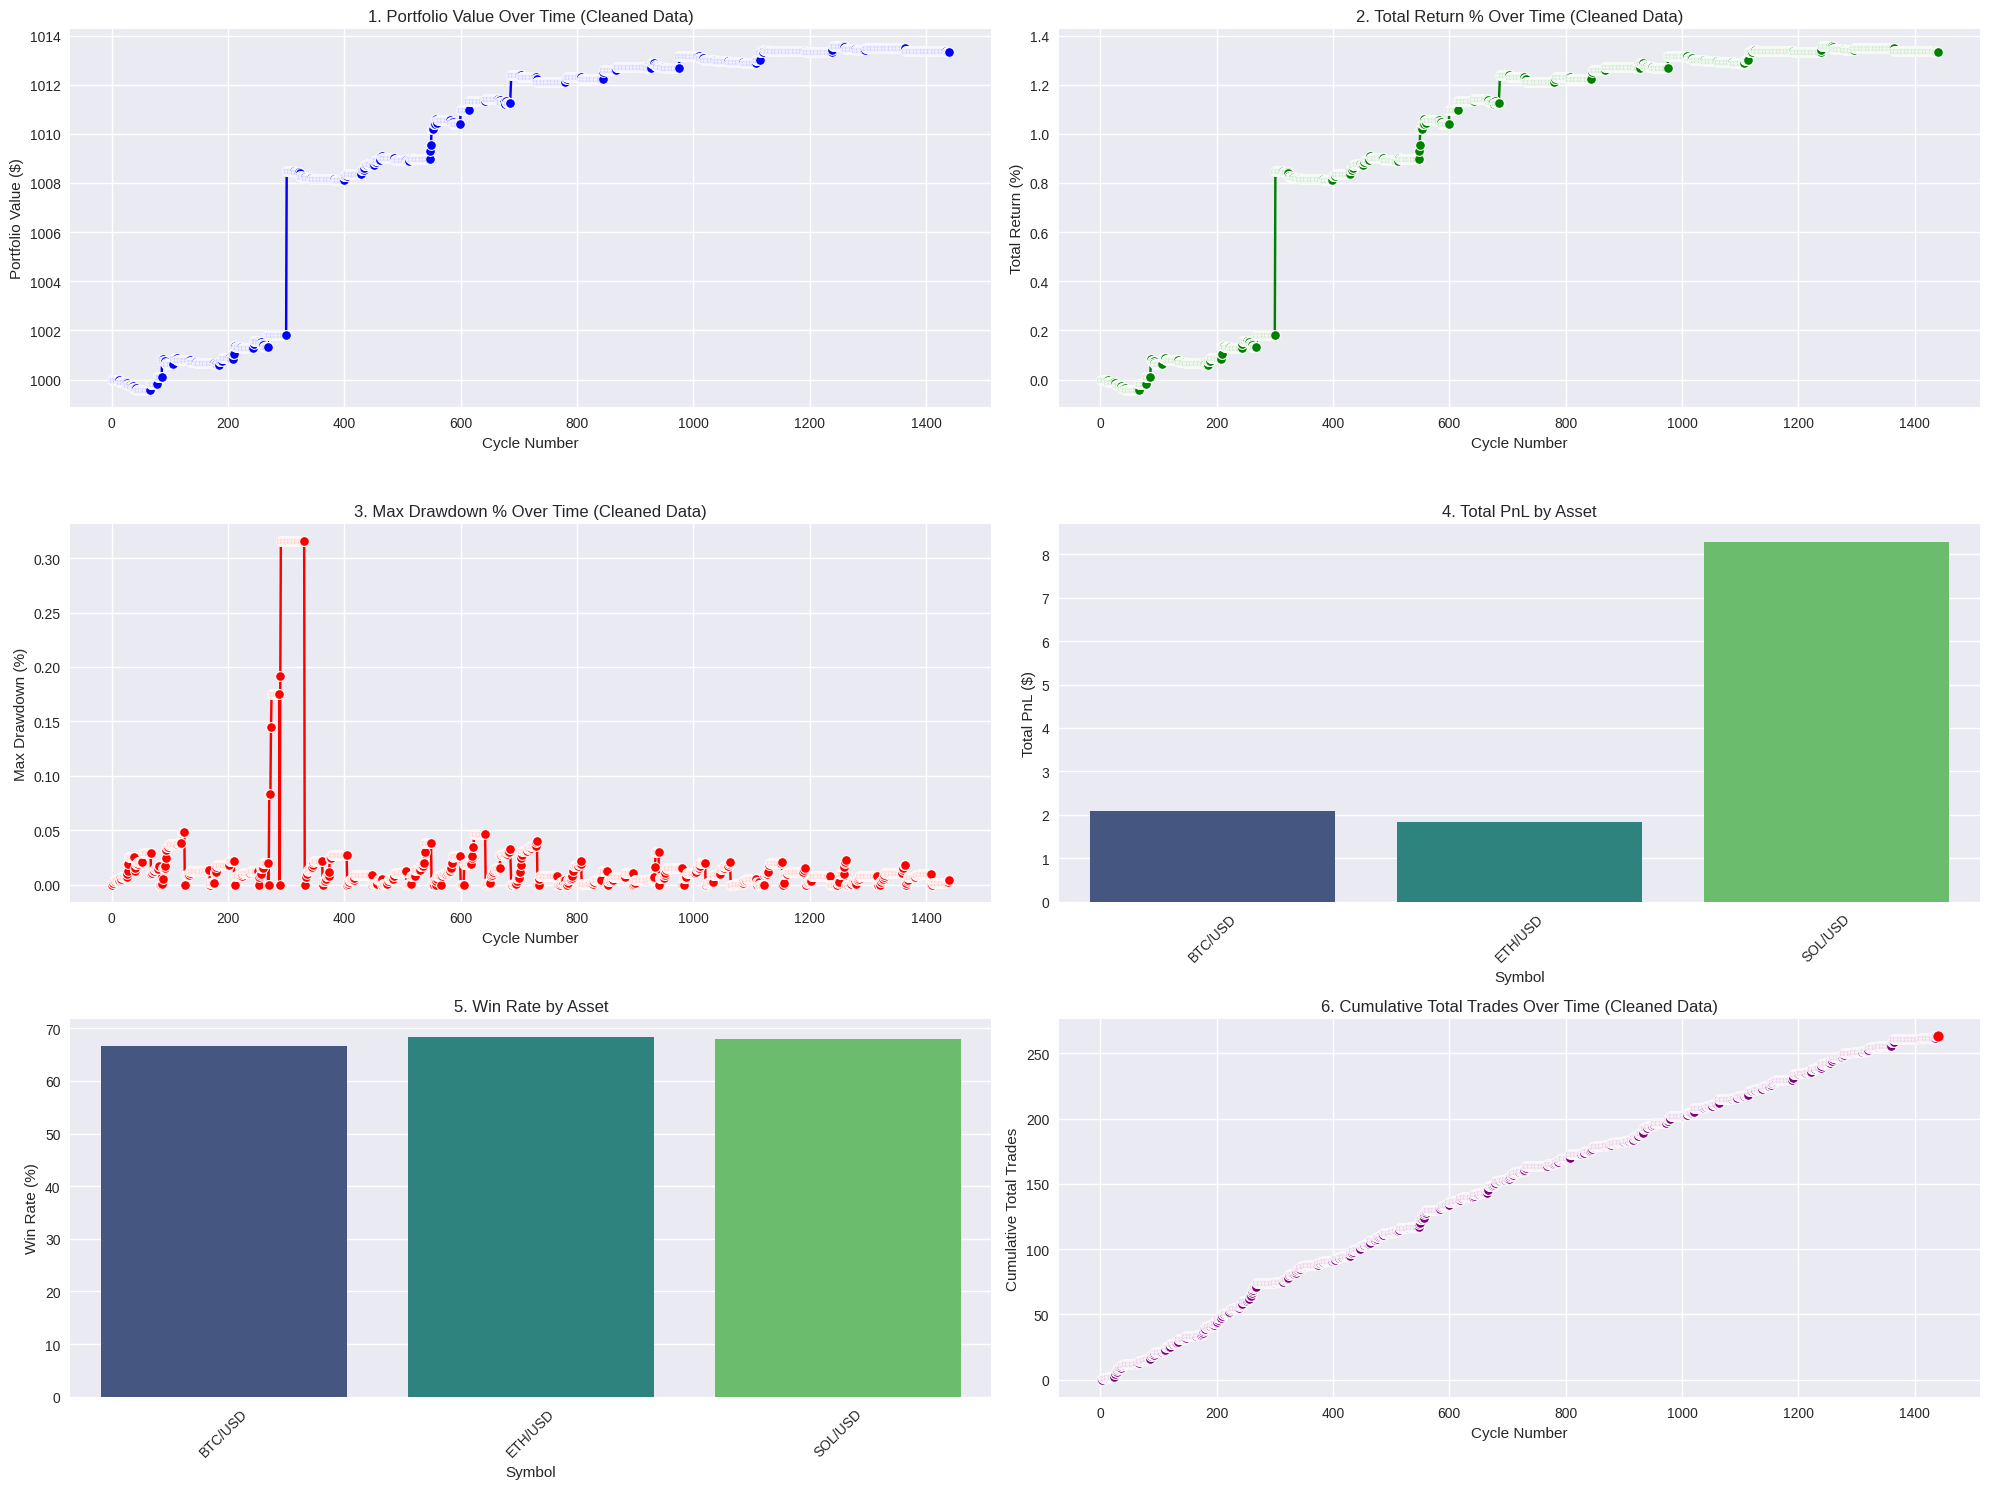

In [4]:
####### important to read ###########################

##BTC - CNN-LSTM with dataset TRAIN:12.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 6.08
#Total Compounded Return: 1842.32%
#Worst Out-of-Sample Max Drawdown: 30.14%
#Total Trades: 510


## ETH - CNN-LSTM with dataset TRAIN:9.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 6.20
#Total Compounded Return: 1757.69%
#Worst Out-of-Sample Max Drawdown: 30.39%
#Total Trades: 432


##SOL -  CNN-LSTM with dataset TRAIN:3.5Y
#### WFO RESULTS - 2.3 years historical-data 2023-2025 WITH TUNER-HYPERBAND

#--- Aggregate Performance ---
#Average Out-of-Sample Sharpe Ratio: 5.10
#Total Compounded Return: 1185.53%
#Worst Out-of-Sample Max Drawdown: 32.68%
#Total Trades: 430

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore') # Suppress Matplotlib/Seaborn warnings for cleaner output

# --- CONFIGURATION ---
DB_PATH = '/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db'
PLOT_DIR = '/content/gdrive/MyDrive/TradingBotLogs/plots/'
os.makedirs(PLOT_DIR, exist_ok=True)
# ---------------------

def get_cycle_performance_data(db_path, start_cycle=None, end_cycle=None, days=None):
    """
    Loads cycle performance data, applying filters for data cleanliness and
    excluding misleading high-value cycles.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)

        query = """
        SELECT
            cycle_number,
            timestamp,
            portfolio_value,
            total_return_pct,
            max_drawdown_pct,
            sharpe_ratio,
            total_trades,
            winning_trades,
            total_pnl,
            runtime_hours
        FROM cycle_performance
        WHERE 1=1
        """
        params = []

        # CRITICAL FILTER: Exclude cycles where portfolio value is unrealistic (i.e., old test runs).
        query += " AND portfolio_value < 5000.00"

        if start_cycle is not None:
            query += " AND cycle_number >= ?"
            params.append(start_cycle)
        if end_cycle is not None:
            query += " AND cycle_number <= ?"
            params.append(end_cycle)
        if days is not None:
            query += " AND datetime(timestamp) >= datetime('now', ?)"
            params.append(f'-{days} days')
        query += " ORDER BY cycle_number"

        df = pd.read_sql_query(query, conn, params=params, dtype={'timestamp': str, 'total_trades': float})

        # 1. Timestamp Conversion and cleanup
        if 'timestamp' in df.columns:
            # Use format='mixed' and errors='coerce' to handle varied/out-of-bounds timestamps
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
            # Drop rows with corrupted timestamps (now NaT)
            df.dropna(subset=['timestamp'], inplace=True)

        # 2. Calculate 'cumulative_trades'
        if 'total_trades' in df.columns:
            # Fill NaN values with 0 and convert to integer for cumsum/plotting
            df['total_trades'] = df['total_trades'].fillna(0).astype(int)
            df['cumulative_trades'] = df['total_trades'].cumsum()

        return df

    except sqlite3.Error as e:
        # Re-raise error to be caught by the main execution block
        raise sqlite3.Error(f"Query Execution Error on cycle_performance: {e}")
    finally:
        if conn:
            conn.close()


def get_asset_performance_summary(db_path, days=None, symbols=None):
    """
    Generates summary of per-asset performance, filtered by realistic portfolio value.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)
        # Query joins asset data with cycle data to filter by portfolio_value
        query = """
        SELECT
            asset_cycle_performance.symbol,
            asset_cycle_performance.pnl,
            asset_cycle_performance.trades,
            cycle_performance.cycle_number,
            cycle_performance.portfolio_value
        FROM asset_cycle_performance
        JOIN cycle_performance ON asset_cycle_performance.cycle_number = cycle_performance.cycle_number
        WHERE cycle_performance.portfolio_value < 5000.00
        """

        # Add optional time filter parameters
        params = []
        if days is not None:
            query += " AND datetime(cycle_performance.timestamp) >= datetime('now', ?)"
            params.append(f'-{days} days')

        asset_df = pd.read_sql_query(query, conn, params=params)

        # Aggregate the clean data
        summary_df = asset_df.groupby('symbol').agg(
            total_trades=('trades', 'sum'),
            total_pnl=('pnl', 'sum'),
            avg_pnl=('pnl', 'mean'),
            winning_trades=('pnl', lambda x: (x > 0).sum())
        ).reset_index()

        if not summary_df.empty:
            summary_df['win_rate'] = (summary_df['winning_trades'] / summary_df['total_trades']) * 100

        return summary_df.fillna(0)

    except sqlite3.Error as e:
        raise sqlite3.Error(f"Query Execution Error on asset_cycle_performance: {e}")
    finally:
        if conn:
            conn.close()


def create_performance_charts(cycle_df, asset_df):
    """Generate and save the visual performance charts (6-panel report)."""
    os.makedirs(PLOT_DIR, exist_ok=True)
    try:
        plt.style.use('seaborn-v0_8')
    except:
        plt.style.use('default')

    if cycle_df.empty or len(cycle_df) < 2:
        print("⚠️ Insufficient cycle performance data for multi-charts.")
        return

    plt.figure(figsize=(20, 15))

    # 1. Portfolio Value Over Time
    plt.subplot(3, 2, 1)
    sns.lineplot(data=cycle_df, x='cycle_number', y='portfolio_value', marker='o', color='blue')
    plt.title('1. Portfolio Value Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    # 2. Total Return %
    plt.subplot(3, 2, 2)
    sns.lineplot(data=cycle_df, x='cycle_number', y='total_return_pct', marker='o', color='green')
    plt.title('2. Total Return % Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Total Return (%)')
    plt.grid(True)

    # 3. Max Drawdown %
    plt.subplot(3, 2, 3)
    sns.lineplot(data=cycle_df, x='cycle_number', y='max_drawdown_pct', marker='o', color='red')
    plt.title('3. Max Drawdown % Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Max Drawdown (%)')
    plt.grid(True)

    # 4. Asset PnL Bar Chart
    plt.subplot(3, 2, 4)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='total_pnl', hue='symbol', palette='viridis', legend=False)
        plt.title('4. Total PnL by Asset')
        plt.xlabel('Symbol')
        plt.ylabel('Total PnL ($)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
        plt.title('4. Total PnL by Asset')

    # 5. Win Rate by Asset
    plt.subplot(3, 2, 5)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='win_rate', hue='symbol', palette='viridis', legend=False)
        plt.title('5. Win Rate by Asset')
        plt.xlabel('Symbol')
        plt.ylabel('Win Rate (%)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
        plt.title('5. Win Rate by Asset')

    # 6. Cumulative Trades Over Time
    plt.subplot(3, 2, 6)
    sns.lineplot(data=cycle_df, x='cycle_number', y='cumulative_trades', marker='o', color='purple')
    plt.scatter(cycle_df['cycle_number'].iloc[-1], cycle_df['cumulative_trades'].iloc[-1], color='red', zorder=5)
    plt.title('6. Cumulative Total Trades Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Cumulative Total Trades')
    plt.grid(True)


    plt.tight_layout()
    plot_path = os.path.join(PLOT_DIR, f'performance_charts_filtered.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📈 All Charts saved to {plot_path}")


def print_detailed_report(cycle_df, asset_df):
    """Prints detailed performance report to console using pre-filtered data."""
    if cycle_df.empty:
        print("⚠️ No cycle data available after filtering.")
        return

    report = {
        'timestamp': datetime.now(),
        'cycle_summary': cycle_df.to_dict('records'),
        'asset_summary': asset_df.to_dict('records'),
        'recommendations': []
    }

    # --- Generate Recommendations ---
    latest_cycle = cycle_df.iloc[-1]

    # Recommendations based on Cycle Summary
    if latest_cycle['max_drawdown_pct'] > 10:
        report['recommendations'].append(
            f"🔻 High drawdown ({latest_cycle['max_drawdown_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - review risk parameters"
        )
    if latest_cycle['sharpe_ratio'] < 1:
        report['recommendations'].append(
            f"⚠️ Low Sharpe Ratio ({latest_cycle['sharpe_ratio']:.2f}) in cycle {latest_cycle['cycle_number']} - assess volatility"
        )
    if latest_cycle['total_return_pct'] > 20:
        report['recommendations'].append(
            f"✅ Strong return ({latest_cycle['total_return_pct']:.2f}%) in cycle {latest_cycle['cycle_number']} - consider scaling"
        )

    # Recommendations based on Asset Summary
    for asset in report['asset_summary']:
        if asset['total_trades'] < 5:
            report['recommendations'].append(
                f"⏳ {asset['symbol']}: Limited trades ({asset['total_trades']}) - collect more data"
            )
        elif asset['win_rate'] < 40:
            report['recommendations'].append(
                f"🔻 {asset['symbol']}: Low win rate ({asset['win_rate']:.1f}%) - review trading strategy"
            )
        if asset['total_pnl'] < 0:
            report['recommendations'].append(
                f"🔻 {asset['symbol']}: Negative PnL (${asset['total_pnl']:,.2f}) - check model performance"
            )
        if asset['win_rate'] > 60 and asset['total_pnl'] > 0:
            report['recommendations'].append(
                f"🎯 {asset['symbol']}: Strong performer (Win Rate: {asset['win_rate']:.1f}%, PnL: ${asset['total_pnl']:,.2f}) - consider scaling"
            )

    # --- Print to Console ---
    print(f"\n{'📊 PERFORMANCE ANALYSIS REPORT (CLEAN DATA) ':═^80}")
    print(f"Generated: {report['timestamp']}")
    print(f"{'':═^80}")

    print(f"\n{'📈 CYCLE PERFORMANCE SUMMARY (HEAD/TAIL) ':─^80}")
    print("Head (First 5 Cycles):")
    print(cycle_df[['cycle_number', 'timestamp', 'portfolio_value', 'total_return_pct',
                    'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'winning_trades', 'total_pnl', 'runtime_hours']].head().to_string(index=False))
    print("\nTail (Last 5 Cycles):")
    print(cycle_df[['cycle_number', 'timestamp', 'portfolio_value', 'total_return_pct',
                    'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'winning_trades', 'total_pnl', 'runtime_hours']].tail().to_string(index=False))

    print(f"\n{'📈 AGGREGATE ASSET PERFORMANCE SUMMARY ':─^80}")
    print(asset_df[['symbol', 'total_trades', 'winning_trades', 'win_rate', 'total_pnl', 'avg_pnl']].to_string(index=False))

    print(f"\n{'🎯 RECOMMENDATIONS ':─^80}")
    for rec in report['recommendations']:
        print(f"   {rec}")
    if not report['recommendations']:
        print("   ✅ No major issues detected")
    print(f"{'':═^80}\n")

    print(f"Total Cycles in Report: {len(cycle_df)}")
    print(f"Total Trades in Report: {cycle_df['total_trades'].sum()}")
    print("--- End of Console Report ---")

# ----------------------------------------------------------------------
# --- MAIN EXECUTION BLOCK (Combines Data Loading and Reporting) ---
try:
    print(f"Attempting to load data from: {DB_PATH} with portfolio filter...")

    # Load all cycle data and asset data using the filter
    cycle_df = get_cycle_performance_data(DB_PATH)
    asset_df = get_asset_performance_summary(DB_PATH)

    if not cycle_df.empty:
        # Print the detailed console report (as requested)
        print_detailed_report(cycle_df, asset_df)

        # Generate and save all charts
        create_performance_charts(cycle_df, asset_df)

    else:
        print("🛑 Plotting aborted: Dataframe is empty due to data loading failure.")
except sqlite3.Error as e:
    print(f"\n❌ CRITICAL DATABASE ERROR: Could not complete reporting.")
    print(f"Reason: {e}")
except Exception as e:
    print(f"\n💥 Critical execution error: {e}")

## NEW CHART

Attempting to load data from: /content/gdrive/MyDrive/TradingBotLogs/trading_bot.db. Timestamps will be converted to America/New_York...

═══════════════📊 PERFORMANCE ANALYSIS REPORT (TIMEZONE: EDT/EST) ═══════════════
Generated: 2025-12-28 13:12:44 EST
════════════════════════════════════════════════════════════════════════════════

────────────📈 TABLE 1: CYCLE PERFORMANCE SNAPSHOT (LATEST 5 CYCLES) ────────────
cycle_number               timestamp portfolio_value total_return_pct max_drawdown_pct sharpe_ratio rolling_sharpe_30  total_trades total_pnl
        1436 2025-12-28 05:50:25 EST       $1,013.34            1.33%            0.00%       -20.06             -3.47             0     $0.00
        1437 2025-12-28 06:22:55 EST       $1,013.34            1.33%            0.00%       -20.91             -3.47             0     $0.00
        1438 2025-12-28 06:54:09 EST       $1,013.34            1.33%            0.00%       -24.24             -3.47             0     $0.00
        1439 20

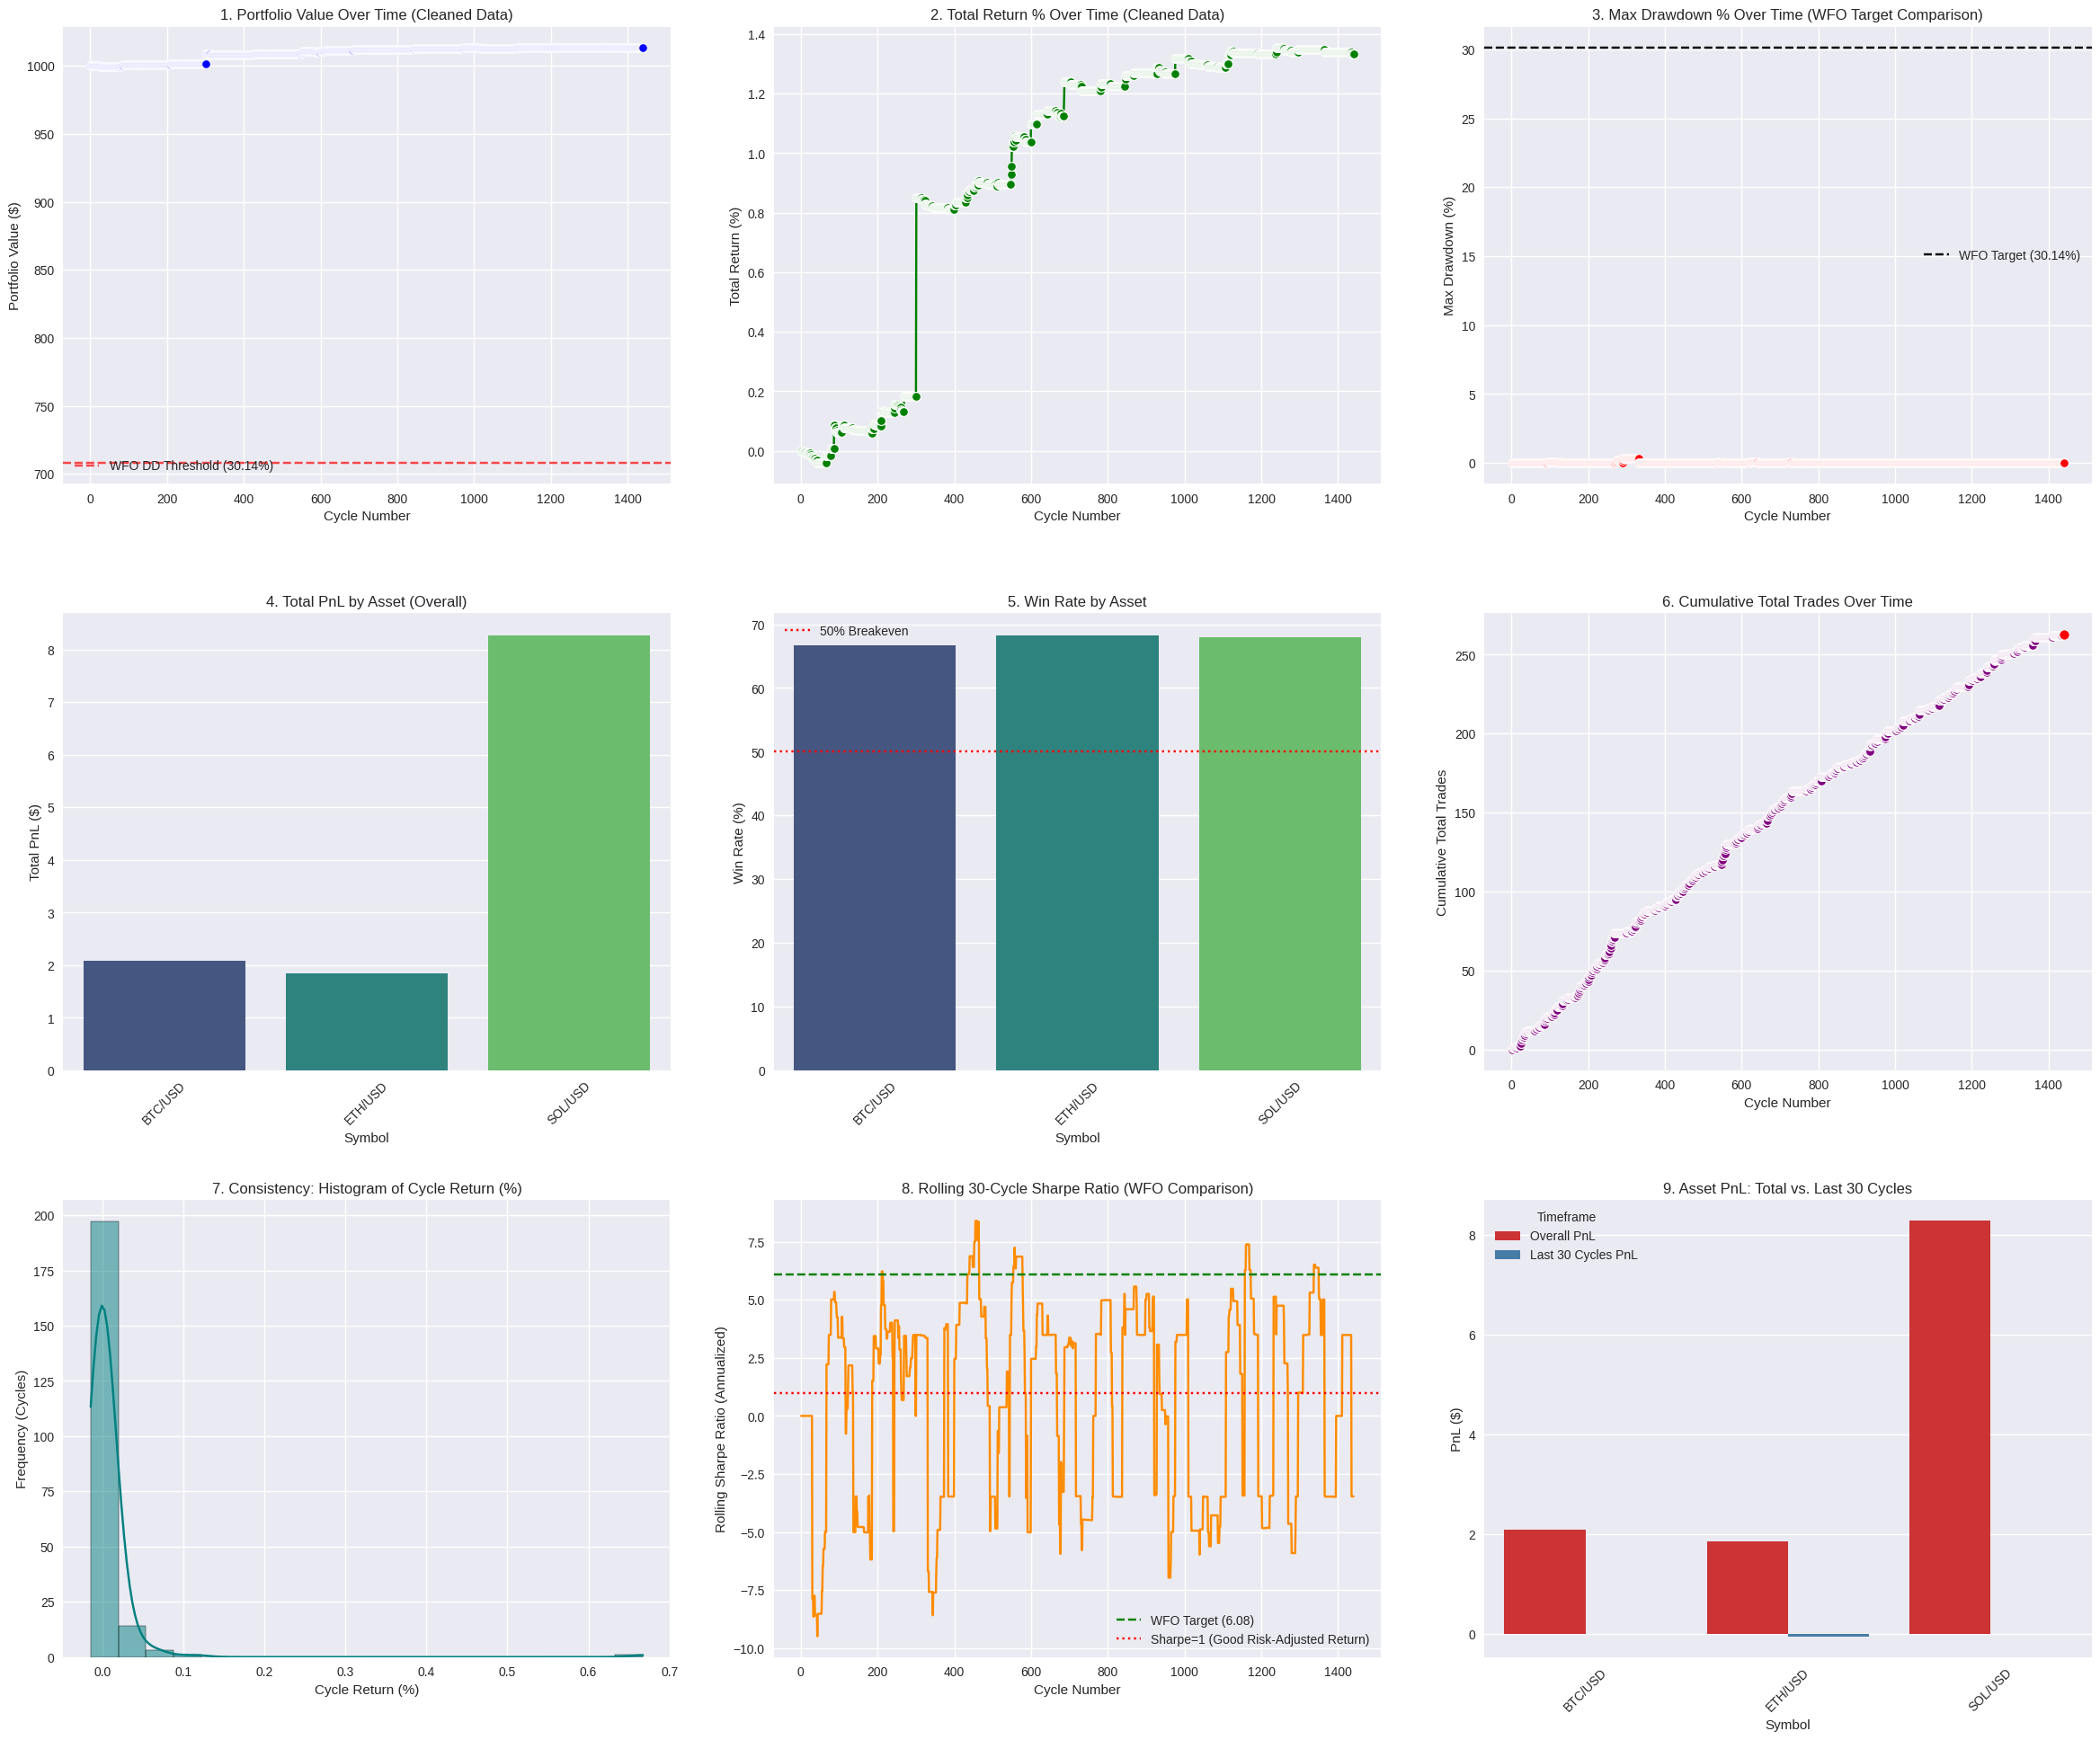

In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime
from warnings import filterwarnings
import pytz
import sys
filterwarnings('ignore') # Suppress Matplotlib/Seaborn warnings

# --- TIMEZONE CONFIGURATION ---
TARGET_TIMEZONE = pytz.timezone('America/New_York')

# --- WFO TARGETS (Based on your BTC model) ---
WFO_SHARPE_TARGET = 6.08
WFO_MAX_DRAWDOWN_TARGET = 30.14
#WFO_TOTAL_RETURN_TARGET = 1842.32
WFO_TOTAL_RETURN_TARGET = 1.30
ROLLING_WINDOW = 30
RECENT_CYCLES = 30

# --- CONFIGURATION ---
DB_PATH = '/content/gdrive/MyDrive/TradingBotLogs/trading_bot.db'
PLOT_DIR = '/content/gdrive/MyDrive/TradingBotLogs/plots/'
os.makedirs(PLOT_DIR, exist_ok=True)
# ---------------------

def get_cycle_performance_data(db_path, start_cycle=None, end_cycle=None, days=None):
    """
    Loads cycle performance data, applying filters, converting timezone, and calculating rolling metrics.
    Hardened to fail gracefully if the timestamp column cannot be parsed.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_path)

        query = """
        SELECT
            cycle_number,
            timestamp,
            portfolio_value,
            total_return_pct,
            max_drawdown_pct,
            sharpe_ratio,
            total_trades,
            winning_trades,
            total_pnl,
            runtime_hours
        FROM cycle_performance
        WHERE 1=1 AND portfolio_value < 5000.00
        ORDER BY cycle_number
        """
        params = []
        df = pd.read_sql_query(query, conn, params=params, dtype={'timestamp': str, 'total_trades': float})

        # 1. Timestamp Conversion and cleanup - FIX APPLIED HERE
        if 'timestamp' in df.columns:
            # Drop timezone offset (+/-HH:MM) from string and convert to datetime
            df['timestamp'] = df['timestamp'].astype(str).str.replace(r'-\d{2}:\d{2}', '', regex=True)
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
            df.dropna(subset=['timestamp'], inplace=True)

            if df.empty:
                return pd.DataFrame()

            # EXPLICIT TIMEZONE CONVERSION
            # Localize to UTC first, then convert to the Target Timezone (America/New_York)
            df['timestamp'] = df['timestamp'].dt.tz_localize(pytz.utc, nonexistent='NaT', ambiguous='NaT')
            df['timestamp'] = df['timestamp'].dt.tz_convert(TARGET_TIMEZONE)


        # 2. Calculate 'cumulative_trades'
        if 'total_trades' in df.columns:
            df['total_trades'] = df['total_trades'].fillna(0).astype(int)
            df['cumulative_trades'] = df['total_trades'].cumsum()

        # 3. Calculate Cycle Returns and Rolling Sharpe Ratio (Conditional on successful timestamp conversion)
        if pd.api.types.is_datetime64_any_dtype(df['timestamp']) and 'total_return_pct' in df.columns:
            df['cycle_return_pct'] = df['total_return_pct'].diff().fillna(0)
            df['cycle_return'] = df['cycle_return_pct'] / 100.0

            rolling_mean = df['cycle_return'].rolling(window=ROLLING_WINDOW).mean()
            rolling_std = df['cycle_return'].rolling(window=ROLLING_WINDOW).std()

            # Annualize the Sharpe Ratio
            df['rolling_sharpe_30'] = (rolling_mean / rolling_std) * np.sqrt(365)
            df['rolling_sharpe_30'] = df['rolling_sharpe_30'].fillna(0)
        else:
             # If calculation failed, fill with dummy columns to prevent errors later
             df['rolling_sharpe_30'] = np.nan
             df['cycle_return_pct'] = np.nan

        return df

    except sqlite3.Error as e:
        print(f"❌ DATABASE ERROR in get_cycle_performance_data: {e}", file=sys.stderr)
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()


def get_asset_performance_summary(db_path, cycle_list=None):
    """Generates summary of per-asset performance, filtered by cycle_number if provided."""
    conn = None
    try:
        conn = sqlite3.connect(db_path)

        query = """
        SELECT
            asset_cycle_performance.symbol,
            asset_cycle_performance.pnl,
            asset_cycle_performance.trades,
            cycle_performance.cycle_number,
            cycle_performance.portfolio_value
        FROM asset_cycle_performance
        JOIN cycle_performance ON asset_cycle_performance.cycle_number = cycle_performance.cycle_number
        WHERE cycle_performance.portfolio_value < 5000.00
        """
        params = []

        if cycle_list is not None and cycle_list:
            placeholders = ','.join('?' for _ in cycle_list)
            query += f" AND asset_cycle_performance.cycle_number IN ({placeholders})"""
            params.extend(cycle_list)

        asset_df = pd.read_sql_query(query, conn, params=params)

        summary_df = asset_df.groupby('symbol').agg(
            total_trades=('trades', 'sum'),
            total_pnl=('pnl', 'sum'),
            avg_pnl=('pnl', 'mean'),
            winning_trades=('pnl', lambda x: (x > 0).sum())
        ).reset_index()

        if not summary_df.empty:
            summary_df['win_rate'] = (summary_df['winning_trades'] / summary_df['total_trades']) * 100

        return summary_df.fillna(0)

    except sqlite3.Error as e:
        print(f"❌ DATABASE ERROR in get_asset_performance_summary: {e}", file=sys.stderr)
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()


def create_performance_charts(cycle_df, asset_df, recent_asset_df):
    """Generate and save the enhanced 9-panel visual performance charts. """
    os.makedirs(PLOT_DIR, exist_ok=True)
    try:
        plt.style.use('seaborn-v0_8')
    except:
        plt.style.use('default')

    if cycle_df.empty or len(cycle_df) < 2:
        print("⚠️ Insufficient cycle performance data for multi-charts.")
        return

    # --- Start 9-Panel Layout ---
    plt.figure(figsize=(24, 20))

    # 1. Portfolio Value Over Time
    plt.subplot(3, 3, 1)
    sns.lineplot(data=cycle_df, x='cycle_number', y='portfolio_value', marker='o', color='blue')
    plt.title('1. Portfolio Value Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Portfolio Value ($)')
    current_max_value = cycle_df['portfolio_value'].max()
    plt.axhline(y=current_max_value * (1 - WFO_MAX_DRAWDOWN_TARGET/100), color='r', linestyle='--', alpha=0.7, label=f'WFO DD Threshold ({WFO_MAX_DRAWDOWN_TARGET}%)')
    plt.legend(loc='lower left')
    plt.grid(True)

    # 2. Total Return %
    plt.subplot(3, 3, 2)
    sns.lineplot(data=cycle_df, x='cycle_number', y='total_return_pct', marker='o', color='green')
    plt.title('2. Total Return % Over Time (Cleaned Data)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Total Return (%)')
    plt.grid(True)

    # 3. Max Drawdown % (Crucial Risk Metric with WFO Comparison)
    plt.subplot(3, 3, 3)
    sns.lineplot(data=cycle_df, x='cycle_number', y='max_drawdown_pct', marker='o', color='red')
    plt.title('3. Max Drawdown % Over Time (WFO Target Comparison)')
    plt.xlabel('Cycle Number')
    plt.ylabel('Max Drawdown (%)')
    plt.axhline(y=WFO_MAX_DRAWDOWN_TARGET, color='k', linestyle='--', label=f'WFO Target ({WFO_MAX_DRAWDOWN_TARGET}%)')
    plt.legend()
    plt.grid(True)

    # 4. Total PnL by Asset (Overall)
    plt.subplot(3, 3, 4)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='total_pnl', hue='symbol', palette='viridis', legend=False)
        plt.title('4. Total PnL by Asset (Overall)')
        plt.xlabel('Symbol')
        plt.ylabel('Total PnL ($)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No overall asset data', ha='center', va='center')
        plt.title('4. Total PnL by Asset (Overall)')

    # 5. Win Rate by Asset
    plt.subplot(3, 3, 5)
    if not asset_df.empty:
        sns.barplot(data=asset_df, x='symbol', y='win_rate', hue='symbol', palette='viridis', legend=False)
        plt.title('5. Win Rate by Asset')
        plt.xlabel('Symbol')
        plt.ylabel('Win Rate (%)')
        plt.xticks(rotation=45)
        plt.axhline(y=50, color='r', linestyle=':', label='50% Breakeven')
        plt.legend()
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'No asset data', ha='center', va='center')
        plt.title('5. Win Rate by Asset')

    # 6. Cumulative Trades Over Time
    plt.subplot(3, 3, 6)
    if 'cumulative_trades' in cycle_df.columns:
        sns.lineplot(data=cycle_df, x='cycle_number', y='cumulative_trades', marker='o', color='purple')
        plt.scatter(cycle_df['cycle_number'].iloc[-1], cycle_df['cumulative_trades'].iloc[-1], color='red', zorder=5)
        plt.title('6. Cumulative Total Trades Over Time')
        plt.xlabel('Cycle Number')
        plt.ylabel('Cumulative Total Trades')
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Data Unavailable (Cumulative Trades Calc Failed)', ha='center', va='center')
        plt.title('6. Cumulative Total Trades Over Time')


    # 7. Consistency: Histogram of Cycle Returns (Conditional Plot)
    plt.subplot(3, 3, 7)
    if 'cycle_return_pct' in cycle_df.columns and not cycle_df['cycle_return_pct'].isnull().all():
        sns.histplot(cycle_df['cycle_return_pct'].replace(0, np.nan).dropna(), bins=20, kde=True, color='teal')
        plt.title('7. Consistency: Histogram of Cycle Return (%)')
        plt.xlabel('Cycle Return (%)')
        plt.ylabel('Frequency (Cycles)')
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'Data Unavailable (Return Calc Failed)', ha='center', va='center')
        plt.title('7. Consistency: Histogram of Cycle Return (%)')

    # 8. Rolling 30-Cycle Sharpe Ratio (Conditional Plot)
    plt.subplot(3, 3, 8)
    if 'rolling_sharpe_30' in cycle_df.columns and not cycle_df['rolling_sharpe_30'].isnull().all():
        sns.lineplot(data=cycle_df, x='cycle_number', y='rolling_sharpe_30', color='darkorange')
        plt.title(f'8. Rolling {ROLLING_WINDOW}-Cycle Sharpe Ratio (WFO Comparison)')
        plt.xlabel('Cycle Number')
        plt.ylabel('Rolling Sharpe Ratio (Annualized)')
        plt.axhline(y=WFO_SHARPE_TARGET, color='g', linestyle='--', label=f'WFO Target ({WFO_SHARPE_TARGET:.2f})')
        plt.axhline(y=1.0, color='r', linestyle=':', label='Sharpe=1 (Good Risk-Adjusted Return)')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Data Unavailable (Sharpe Calc Failed)', ha='center', va='center')
        plt.title(f'8. Rolling {ROLLING_WINDOW}-Cycle Sharpe Ratio (WFO Comparison)')

    # 9. Recent vs. Total Asset PnL (Time Segmentation)
    plt.subplot(3, 3, 9)
    if not asset_df.empty and not recent_asset_df.empty:
        asset_df_merged = asset_df[['symbol', 'total_pnl']].rename(columns={'total_pnl': 'Overall PnL'})
        recent_asset_df_merged = asset_df_recent[['symbol', 'total_pnl']].rename(columns={'total_pnl': f'Last {RECENT_CYCLES} Cycles PnL'})

        comparison_df = pd.merge(asset_df_merged, recent_asset_df_merged, on='symbol', how='outer').fillna(0)

        plot_data = comparison_df.melt(id_vars='symbol', value_vars=['Overall PnL', f'Last {RECENT_CYCLES} Cycles PnL'],
                                  var_name='Timeframe', value_name='PnL')

        sns.barplot(data=plot_data, x='symbol', y='PnL', hue='Timeframe', palette='Set1')
        plt.title(f'9. Asset PnL: Total vs. Last {RECENT_CYCLES} Cycles')
        plt.xlabel('Symbol')
        plt.ylabel('PnL ($)')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y')
    else:
        plt.text(0.5, 0.5, 'Insufficient asset data for comparison', ha='center', va='center')
        plt.title('9. Asset PnL: Total vs. Recent Trend')

    plt.tight_layout(pad=3.0)
    plot_path = os.path.join(PLOT_DIR, f'performance_charts_9panel_enhanced_FIXED.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📈 Enhanced 9-Panel Dashboard saved to {plot_path}")


def print_detailed_report(cycle_df, asset_df_overall):
    """Prints detailed performance report to console using structured tables. (Fixed to use raw numeric data for recommendations)"""
    if cycle_df.empty:
        print("⚠️ No cycle data available after filtering.")
        return

    # --- 1. PREPARE DATA FOR TABLES ---
    latest_cycle = cycle_df.iloc[-1]

    # Check for presence of calculated columns, set to NaN if missing
    has_rolling_sharpe = 'rolling_sharpe_30' in cycle_df.columns and not cycle_df['rolling_sharpe_30'].isnull().all()

    # TABLE 1: Cycle Performance Snapshot
    cols_to_display = ['cycle_number', 'portfolio_value', 'total_return_pct', 'max_drawdown_pct', 'sharpe_ratio', 'total_trades', 'total_pnl']
    if 'timestamp' in cycle_df.columns:
        cols_to_display.insert(1, 'timestamp')
    if has_rolling_sharpe:
        cols_to_display.insert(cols_to_display.index('sharpe_ratio') + 1, 'rolling_sharpe_30')

    table1_df = cycle_df.tail(5)[cols_to_display].copy()

    # Format the data for clean console output
    if 'timestamp' in table1_df.columns:
        if pd.api.types.is_datetime64_any_dtype(table1_df['timestamp']):
            table1_df['timestamp'] = table1_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S %Z')
        else:
            table1_df['timestamp'] = table1_df['timestamp'].fillna('N/A-RAW')

    table1_df['portfolio_value'] = table1_df['portfolio_value'].map('${:,.2f}'.format)
    table1_df['total_return_pct'] = table1_df['total_return_pct'].map('{:.2f}%'.format)
    table1_df['max_drawdown_pct'] = table1_df['max_drawdown_pct'].map('{:.2f}%'.format)
    table1_df['sharpe_ratio'] = table1_df['sharpe_ratio'].map('{:.2f}'.format)
    if has_rolling_sharpe:
        table1_df['rolling_sharpe_30'] = table1_df['rolling_sharpe_30'].map('{:.2f}'.format)
    table1_df['total_pnl'] = table1_df['total_pnl'].map('${:,.2f}'.format)


    # TABLE 2: Asset Contribution Analysis
    table2_df = asset_df_overall[['symbol', 'total_trades', 'winning_trades', 'win_rate', 'total_pnl', 'avg_pnl']].copy()
    table2_df['win_rate'] = table2_df['win_rate'].map('{:.1f}%'.format)
    table2_df['total_pnl'] = table2_df['total_pnl'].map('${:,.2f}'.format)
    table2_df['avg_pnl'] = table2_df['avg_pnl'].map('${:,.4f}'.format)


    # TABLE 3: WFO Comparison
    def get_status(live, target, metric):
        if pd.isna(live): return "N/A"
        if metric == 'drawdown':
            return "Worse" if live > target else "Better"
        if metric in ['sharpe', 'return']:# Return/Sharpe: Higher is better
            return "Better" if live > target else "Worse"
        return ""

    # Get raw numeric values for comparison (robust against NaN if calculations failed)
    latest_dd = latest_cycle['max_drawdown_pct']
    latest_sr = latest_cycle['sharpe_ratio']
    latest_rolling_sr = latest_cycle.get('rolling_sharpe_30', np.nan)
    latest_return = cycle_df['total_return_pct'].iloc[-1]


    table3_data = [
        {'Metric': 'Max Drawdown', 'WFO Target': f'{WFO_MAX_DRAWDOWN_TARGET:.2f}%',
         'Latest Live Value': f"{latest_dd:.2f}%" if pd.notna(latest_dd) else "N/A",
         'Status': get_status(latest_dd, WFO_MAX_DRAWDOWN_TARGET, 'drawdown')},

        {'Metric': 'Sharpe Ratio (Overall)', 'WFO Target': f'{WFO_SHARPE_TARGET:.2f}',
         'Latest Live Value': f"{latest_sr:.2f}" if pd.notna(latest_sr) else "N/A",
         'Status': get_status(latest_sr, WFO_SHARPE_TARGET, 'sharpe')},

        {'Metric': f'Rolling {ROLLING_WINDOW}-Cycle SR', 'WFO Target': f'{WFO_SHARPE_TARGET:.2f}',
         'Latest Live Value': f"{latest_rolling_sr:.2f}" if pd.notna(latest_rolling_sr) else "N/A (Calc Failed)",
         'Status': get_status(latest_rolling_sr, WFO_SHARPE_TARGET, 'sharpe')},

        {'Metric': 'Total Compounded Return', 'WFO Target': f'{WFO_TOTAL_RETURN_TARGET:.2f}%',
         'Latest Live Value': f"{latest_return:.2f}%" if pd.notna(latest_return) else "N/A",
         'Status': get_status(latest_return, WFO_TOTAL_RETURN_TARGET, 'return')},
    ]
    table3_df = pd.DataFrame(table3_data)


    # --- 2. PRINT TO CONSOLE ---
    current_time_edt = datetime.now(TARGET_TIMEZONE).strftime('%Y-%m-%d %H:%M:%S %Z')

    print(f"\n{'📊 PERFORMANCE ANALYSIS REPORT (TIMEZONE: EDT/EST) ':═^80}")
    print(f"Generated: {current_time_edt}")
    print(f"{'':═^80}")

    print(f"\n{'📈 TABLE 1: CYCLE PERFORMANCE SNAPSHOT (LATEST 5 CYCLES) ':─^80}")
    print(table1_df.to_string(index=False))

    print(f"\n{'⚖️ TABLE 3: WFO TARGET COMPARISON (BTC Model) ':─^80}")
    print(table3_df.to_string(index=False))

    print(f"\n{'💰 TABLE 2: ASSET CONTRIBUTION ANALYSIS (OVERALL) ':─^80}")
    print(table2_df.to_string(index=False))

    # --- RECOMMENDATIONS (Uses raw numeric data from asset_df_overall) ---
    report_recommendations = []

    if pd.notna(latest_dd) and latest_dd > WFO_MAX_DRAWDOWN_TARGET * 1.1:
        report_recommendations.append(
            f"🔻 Critical Drawdown: Current DD ({latest_dd:.2f}%) significantly exceeds WFO target ({WFO_MAX_DRAWDOWN_TARGET:.2f}%). **IMMEDIATE REVIEW REQUIRED.**"
        )
    # Check if Rolling SR is below 80% of the target
    if pd.notna(latest_rolling_sr) and latest_rolling_sr < WFO_SHARPE_TARGET * 0.8:
        report_recommendations.append(
            f"⚠️ Low Rolling Sharpe: Recent risk-adjusted return ({latest_rolling_sr:.2f}) is 20% below WFO target. **Model may be degrading.**"
        )
    # Note: The original data warning is removed as the fix should prevent it.

    # Use the raw, numeric asset_df_overall
    for index, asset in asset_df_overall.iterrows():
        total_pnl = asset['total_pnl']
        total_trades = asset['total_trades']
        win_rate = asset['win_rate']

        if total_pnl < 0 and total_trades > 10:
            report_recommendations.append(
                f"❌ Underperformer: {asset['symbol']} has negative PnL (${total_pnl:.2f}) and sufficient trades. **Consider disabling or retuning.**"
            )
        elif win_rate > 65 and total_pnl > 0:
            report_recommendations.append(
                f"🎯 Strong Performer: {asset['symbol']} is highly effective (Win Rate: {win_rate:.1f}%, PnL: ${total_pnl:.2f}). **Consider scaling exposure.**"
            )

    print(f"\n{'🎯 ACTIONABLE RECOMMENDATIONS ':─^80}")
    for rec in report_recommendations:
        print(f"   {rec}")
    if not report_recommendations:
        print("   ✅ No critical issues detected against WFO targets or trade performance.")
    print(f"{'':═^80}\n")
    print("--- End of Console Report ---")

# ----------------------------------------------------------------------
# --- MAIN EXECUTION BLOCK (Combines Data Loading and Reporting) ---
if __name__ == '__main__':
    try:
        print(f"Attempting to load data from: {DB_PATH}. Timestamps will be converted to {TARGET_TIMEZONE.zone}...")

        cycle_df = get_cycle_performance_data(DB_PATH)

        if cycle_df.empty:
            print("🛑 Execution aborted: Dataframe is empty after filtering/loading.")
        else:
            asset_df_overall = get_asset_performance_summary(DB_PATH)

            recent_cycle_list = cycle_df['cycle_number'].tail(RECENT_CYCLES).tolist()
            asset_df_recent = get_asset_performance_summary(DB_PATH, cycle_list=recent_cycle_list)

            # Print the structured console report
            print_detailed_report(cycle_df, asset_df_overall)

            # Generate and save all charts
            create_performance_charts(cycle_df, asset_df_overall, asset_df_recent)

    except Exception as e:
        print(f"\n💥 Critical execution error: {e}", file=sys.stderr)